Importing Libraries

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.7.1+cu126
True


Dataset

In [4]:
training_data = datasets.MNIST(
    root = "dataset",
    train = True,
    transform = transforms.ToTensor(),
    download=True
)

testing_data = datasets.MNIST(
    root = "dataset",
    transform=transforms.ToTensor(),
    train = False,
    download=True
)

In [5]:
validation_data = list()
for i in range(len(testing_data)//2):
    validation_x = testing_data[i][0]
    validation_y = testing_data[i][1]
    validation_data.append((validation_x, validation_y))

In [6]:
print(f"Type of each entry in Dataset: {type(training_data[0])}")
print(f"Length of each entry: {len(training_data[0])}")
print(f"Shape of Image: {training_data[0][0].shape}")

Type of each entry in Dataset: <class 'tuple'>
Length of each entry: 2
Shape of Image: torch.Size([1, 28, 28])


In [7]:
print(f"Length of Training Data {len(training_data)}")
print(f"Length of Validation Data {len(validation_data)}")
print(f"Length of Testing Data {len(testing_data)}")

Length of Training Data 60000
Length of Validation Data 5000
Length of Testing Data 10000


In [8]:
input_features = tuple(training_data.__getitem__(0)[0].shape)
output_labels = sorted(set([training_data.__getitem__(label)[1] for label in range(len(training_data))]))
print(f"Shape of the input features : {input_features}")
print(f"Labels for the inputs : {output_labels}")

Shape of the input features : (1, 28, 28)
Labels for the inputs : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Model

In [245]:
OUTPUT_CHANNELS = 4
KERNEL_SIZE = (3,3)
HIDDEN_UNITS_1 = 512
HIDDEN_UNITS_2 = 64
class Number_Recognition_Model(nn.Module):
    def __init__(self, input_features, output_labels):
        super().__init__()
        
        C, H, W = input_features
        self.conv_layer_1 = nn.Conv2d(in_channels=C, out_channels=OUTPUT_CHANNELS, kernel_size=KERNEL_SIZE) 
        self.relu_layer = nn.ReLU()
        self.maxpool_layer_1 = nn.MaxPool2d(kernel_size=KERNEL_SIZE, stride = (1,1))
        self.conv_layer_2 = nn.Conv2d(in_channels=OUTPUT_CHANNELS, out_channels=2*OUTPUT_CHANNELS, kernel_size=KERNEL_SIZE)
        self.maxpool_layer_2 = nn.MaxPool2d(kernel_size=KERNEL_SIZE)
        self.flatten_layer = nn.Flatten()
        self.linear_layer_1 = nn.Linear(in_features=392, out_features=HIDDEN_UNITS_2)
        self.activation_layer = nn.LeakyReLU()
        # self.linear_layer_2 = nn.Linear(in_features=HIDDEN_UNITS_1, out_features=HIDDEN_UNITS_2)
        self.linear_layer_final = nn.Linear(in_features=HIDDEN_UNITS_2, out_features=output_labels)
        self.dropout_layer = nn.Dropout(0.1) 
    
    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.relu_layer(x)
        x = self.maxpool_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.relu_layer(x)
        x = self.maxpool_layer_2(x)
        x = self.flatten_layer(x)
        x = self.linear_layer_1(x)
        x = self.dropout_layer(x)
        x = self.activation_layer(x)
        # x = self.linear_layer_2(x)
        # x = self.activation_layer(x)
        logits = self.linear_layer_final(x)

        return logits

In [246]:
model = Number_Recognition_Model(input_features=input_features, output_labels=len(output_labels))
model = model.to(device=device)

In [157]:
cnt = 0
params = list(model.parameters())
for i in range(len(params)):
    cnt += params[i].numel()
    # break
print(cnt)

26138


Loss Function

In [134]:
loss_fn = nn.CrossEntropyLoss()

Model Training

In [389]:
training_batches = DataLoader(training_data, batch_size = 64, shuffle=True)
validation_batches = DataLoader(validation_data, batch_size = 64, shuffle=True)

In [390]:
len(validation_batches), len(training_batches)

(79, 938)

In [391]:
training_iterator = training_batches._get_iterator()
validation_iterator = validation_batches._get_iterator()

In [392]:
track_train_loss = list()
track_val_loss = list()
track_train_epoch = list()
track_val_epoch = list()

EPOCHES = len(training_batches)
LR = 0.0000001

model.train()
for epoch in range(EPOCHES):

    optimizer = torch.optim.Adam(params=model.parameters(),lr=LR) 
    batch = next(training_iterator)
    
    x = batch[0]
    y = batch[1]

    x = x.to(device)
    y = y.to(device)

    probs = model(x)

    loss = loss_fn(probs, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    track_train_loss.append(loss.item())
    track_train_epoch.append(epoch)
    
    #### Validation Testing ####

    if epoch % 50 == 0:
        batch = next(validation_iterator)
        x = batch[0].to(device)
        y = batch[1].to(device)

        model.eval()
        
        with torch.inference_mode():
            probs = model(x)
            loss_val = loss_fn(probs, y)
            track_val_loss.append(loss_val.item())
            track_val_epoch.append(epoch)
        
        model.train()
        print(f"training_loss: {loss.item()}, loss_val: {loss_val.item()}")

    # if epoch % 200 == 0:
    #     LR = LR / 10
    # break

training_loss: 0.02674139104783535, loss_val: 0.11358929425477982
training_loss: 0.14787186682224274, loss_val: 0.12932723760604858
training_loss: 0.15415434539318085, loss_val: 0.1869494616985321
training_loss: 0.02974225953221321, loss_val: 0.008211569860577583
training_loss: 0.02215055748820305, loss_val: 0.24306483566761017
training_loss: 0.16310127079486847, loss_val: 0.17900720238685608
training_loss: 0.3689250946044922, loss_val: 0.041796084493398666
training_loss: 0.09950408339500427, loss_val: 0.08603490889072418
training_loss: 0.10910902172327042, loss_val: 0.0012409009505063295
training_loss: 0.2348460555076599, loss_val: 0.07656583935022354
training_loss: 0.02909974381327629, loss_val: 0.027153803035616875
training_loss: 0.054075296968221664, loss_val: 0.07037560641765594
training_loss: 0.2305557280778885, loss_val: 0.08702656626701355
training_loss: 0.03510861471295357, loss_val: 0.08007623255252838
training_loss: 0.19391301274299622, loss_val: 0.1490631252527237
training_

In [388]:
track_train_epoch_np = np.array(track_train_epoch)
track_val_epoch_np = np.array(track_val_epoch)
track_train_loss_np = np.array(track_train_loss)
track_val_loss_np = np.array(track_val_loss)

print(f"Average Training Loss: {np.mean(track_train_loss)}")
print(f"Average Validation Loss: {np.mean(track_val_loss)}")

Average Training Loss: 0.10964777308758468
Average Validation Loss: 0.10422005685732554


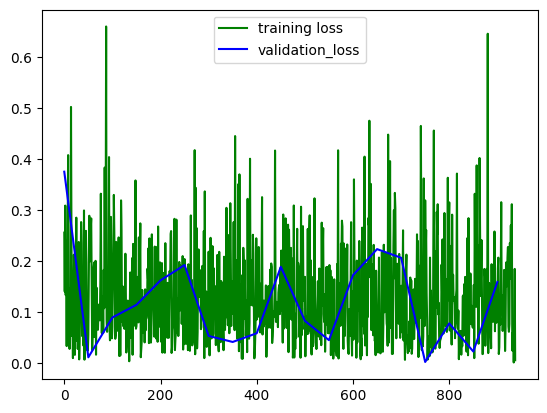

In [360]:
plt.plot(track_train_epoch_np,track_train_loss_np, color = "g",label="training loss")
plt.plot(track_val_epoch_np, track_val_loss_np, color = "b", label="validation_loss")
plt.legend()
plt.show()

Model Saving & Loading

In [398]:
VERSION = "v4"
MODEL_PATH = f"models/model_weights_{VERSION}.pth"

In [396]:
torch.save(model.state_dict(), MODEL_PATH)

In [399]:
model.load_state_dict(torch.load(MODEL_PATH,weights_only=True))

<All keys matched successfully>

Model Evaluation

In [182]:
testing_record = testing_data.__getitem__(5000)
testing_x = testing_record[0].unsqueeze(dim=0)
testing_y = torch.tensor(testing_record[1]).unsqueeze(dim=0)
for i in range(5001,len(testing_data)):
    testing_record = testing_data.__getitem__(i)
    testing_x = torch.cat((testing_x, testing_record[0].unsqueeze(dim=0)), dim=0)
    testing_y = torch.cat((testing_y, torch.tensor(testing_record[1]).unsqueeze(dim=0)), dim=0)

In [172]:
print(f"Shape of Test Inputs: {testing_x.shape}")
print(f"Shape of Test Labels: {testing_y.shape} ")

Shape of Test Inputs: torch.Size([5000, 1, 28, 28])
Shape of Test Labels: torch.Size([5000]) 


In [400]:
predictions = list()
with torch.inference_mode() :
    model.eval()
    x = testing_x.to(device=device)
    y = testing_y.to(device=device)
    logits = model(x)
    loss = loss_fn(logits, y)
    print(f"Testing Loss: {loss}")

Testing Loss: 0.03920236974954605


In [401]:
predictions = torch.argmax(nn.functional.softmax(logits, dim=1), dim = 1).to("cpu").numpy()
accuracy_score(testing_y.numpy(), predictions)

0.9886

Model Testing

In [339]:
idx = np.random.randint(low=0, high=len(testing_data), size=(10,))
images = list()
for i in idx:
    images.append(testing_data[i][0].squeeze(dim=0))

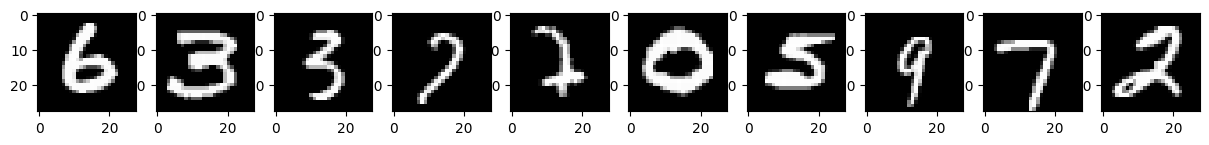

In [340]:
fig , axes = plt.subplots(1,10)
fig.set_size_inches(15, 150)
for i ,img in enumerate(images):
    axes[i].imshow(img,cmap="gray")
plt.show()

In [341]:
x = images[0].reshape(1,1,28,28)

for i in range(1,len(images)):
    x = np.concatenate((x, images[i].reshape(1,1,28,28)), axis=0)

x = torch.from_numpy(x)
x = x.type(torch.float32)
x = x.to(device=device)

In [342]:
with torch.inference_mode():
    model.eval()
    preds = model(x)
    print(torch.argmax(preds, dim=1))

tensor([6, 3, 3, 7, 2, 0, 5, 9, 7, 2], device='cuda:0')
